# Mobile vehical tracking and movement data visualization


### Introduction

We will create an interactive visualization for vehical tracking making use of Folium HeatMapWithTime.
Also, we will create trajectories from MovingPandas and use hvplot to generate an interactive visualization for movement data






## Jupyter notebook setup

In [1]:
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [468]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, read_file
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import folium
import hvplot
import holoviews as hvp
import gpxpy
import movingpandas as mpd
print(mpd.__version__)
import branca.colormap as cm
from folium.plugins import HeatMap, HeatMapWithTime
import warnings
warnings.simplefilter("ignore")

0.5.rc1


## Trajectory creation from GPX data



In [270]:
df1=open('data/20201021-183623.gpx','r')
gpx = gpxpy.parse(df1)

In [271]:
data = gpx.tracks[0].segments[0].points

In [272]:
## Start Position
start = data[0]
## End Position
finish = data[-1]


In [273]:
#Creating a panda dataframe from the above points list that we extracted out of gpx data
df = pd.DataFrame(columns=['lon', 'lat', 'alt', 'time','speed'])
for point in data:
    df=df.append({'lon':point.longitude,'lat':point.latitude,'alt':point.elevation,'time':point.time,'speed':point.speed},ignore_index=True)

In [274]:
df.head()

,lon,lat,alt,time,speed
0,28.062550,-26.022658,1434.753,2020-10-21 16:36:23+00:00,1.15
1,28.062540,-26.022656,1435.579,2020-10-21 16:36:24+00:00,0.93
2,28.062524,-26.022653,1435.531,2020-10-21 16:36:25+00:00,1.70
3,28.062507,-26.022651,1434.636,2020-10-21 16:36:26+00:00,1.52
4,28.062491,-26.022649,1434.525,2020-10-21 16:36:27+00:00,1.52


In [275]:
#movingpandas expects a trajectory id and time column as index ,so we need to create both of them.In below example we only have one trajectory for my trip from home to grocery store so let's put a unique ID column
df = df.set_index('time').tz_localize(None)
df['traj_id'] = 1
df.head()

,lon,lat,alt,speed,traj_id
time,,,,,
2020-10-21 16:36:23,28.062550,-26.022658,1434.753,1.15,1
2020-10-21 16:36:24,28.062540,-26.022656,1435.579,0.93,1
2020-10-21 16:36:25,28.062524,-26.022653,1435.531,1.70,1
2020-10-21 16:36:26,28.062507,-26.022651,1434.636,1.52,1
2020-10-21 16:36:27,28.062491,-26.022649,1434.525,1.52,1


In [276]:
df.head()
print('finished reading {}'.format(len(df)))

finished reading 1286


<AxesSubplot:xlabel='time'>

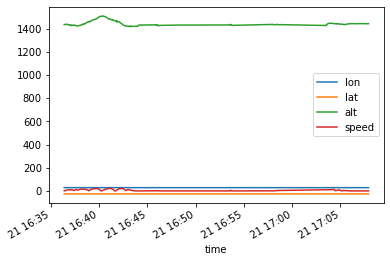

In [31]:
df.plot()

In [277]:
#Above plot does not reflect underneath geometrical aspect so, lets create geometrical dataframe using geopandas
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['lon'],df['lat']),crs='epsg:4326')
gdf.head()

,lon,lat,alt,speed,traj_id,geometry
time,,,,,,
2020-10-21 16:36:23,28.062550,-26.022658,1434.753,1.15,1,POINT (28.06255 -26.02266)
2020-10-21 16:36:24,28.062540,-26.022656,1435.579,0.93,1,POINT (28.06254 -26.02266)
2020-10-21 16:36:25,28.062524,-26.022653,1435.531,1.70,1,POINT (28.06252 -26.02265)
2020-10-21 16:36:26,28.062507,-26.022651,1434.636,1.52,1,POINT (28.06251 -26.02265)
2020-10-21 16:36:27,28.062491,-26.022649,1434.525,1.52,1,POINT (28.06249 -26.02265)


<AxesSubplot:>

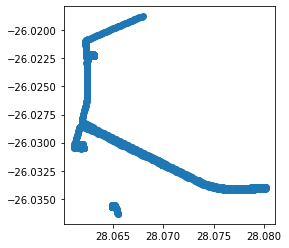

In [278]:
gdf.plot()

In [279]:
#check CRS of geo dataframe
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Let's create trajectories with TrajectoryCollection movingpandas package


In [280]:
traj_collection = mpd.TrajectoryCollection(gdf, 'traj_id')


### Ploting Trajectory Collection

<AxesSubplot:>

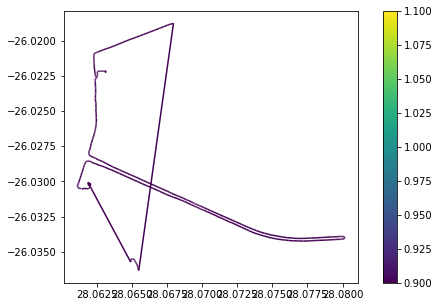

In [284]:
traj_collection.plot(column='traj_id', legend=True, figsize=(9,5))

#### Lets create an interactive plot to visualize trajectory collection

In [285]:
xplot=traj_collection.hvplot(c='speed',hover_cols=[speed],width=700, height=400, line_width=7.0, tiles='ESRI', cmap='Viridis', colorbar=True, clim=(0,20))


In [286]:
hvplot.save(xplot,'movement_data_viz_using_hvplot.html')

#### Creation of placemarks and start and end point of vehicle

In [436]:
start_point=traj_collection.get_start_locations()
end_point=traj_collection.get_end_locations()
start_point['Location_name'] = 'Mobile Generator Warehouse'
end_point['Location_name'] = 'Mobile Generator Warehouse Extension'
end_point['Location_name']

2020-10-21 17:07:55    Mobile Generator Warehouse Extension
Name: Location_name, dtype: object

In [288]:
place_marks = read_file('data/20201021-183623.gpx')
place_marks.head()

,ele,time,magvar,geoidheight,name,cmt,desc,src,url,urlname,sym,type,fix,sat,hdop,vdop,pdop,ageofdgpsdata,dgpsid,geometry
0,1426.791,2020-10-21T16:46:06+00:00,None,None,Network site 1,None,None,None,None,None,None,None,None,10,None,None,None,None,None,POINT (28.06191 -26.03011)
1,1435.686,2020-10-21T16:57:41+00:00,None,None,Network site 2,None,None,None,None,None,None,None,None,15,None,None,None,None,None,POINT (28.06492 -26.03572)
2,1442.441,2020-10-21T17:07:01+00:00,None,None,Network site 3,None,None,None,None,None,None,None,None,18,None,None,None,None,None,POINT (28.06313 -26.02224)


In [458]:
xyz= place_marks.hvplot(c='name',hover_cols=['name'],width=150, height=100, line_width=7.0, tiles='StamenTonerBackground', cmap='Viridis', colorbar=True, clim=(0,20),value_label='name',legend='top')


:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [x,y]   (name)

#### Layered map creation containing place markers and start - end points of vehicle

In [467]:
layered_plot=( traj_collection.hvplot(c='speed', width=1000, height=500, line_width=4.0, tiles='OSM', cmap='Viridis', colorbar=True, clim=(0,20),value_label='speed') *(start_point.hvplot(geo=True, size=200, color='green',hover_cols=['Location_name']) *(end_point.hvplot(geo=True, size=200, color='green',hover_cols=['Location_name'])*(place_marks.hvplot(geo=True, size=200, color='orange',hover_cols=['name']))) ))

hvplot.save(layered_plot,'movement_data_speed_viz_using_hvplot.html')

#### Let's generate heatmap with time to animate the vehicle tracking

In [305]:
heat = gdf[['lat','lon']]
heat.reset_index(drop=True,inplace=True)

heat.head()

,lat,lon
0,-26.022658,28.062550
1,-26.022656,28.062540
2,-26.022653,28.062524
3,-26.022651,28.062507
4,-26.022649,28.062491


In [306]:
heat_data = list(heat.values)
heat_data[:10]

[array([-26.02265772,  28.06255005]),
 array([-26.02265565,  28.06253986]),
 array([-26.02265279,  28.06252398]),
 array([-26.02265065,  28.06250702]),
 array([-26.02264895,  28.06249117]),
 array([-26.02264778,  28.06247802]),
 array([-26.02264937,  28.06246826]),
 array([-26.02265236,  28.06245695]),
 array([-26.022659  ,  28.06244424]),
 array([-26.02266762,  28.06243341])]

#### HeatMap generation  for the heat data

In [307]:

m = folium.Map([-26.022658,28.062550], zoom_start=10, tiles='cartodbpositron')
HeatMap(heat_data).add_to(m)
m

#### Gardient experiment on HeatMap

In [308]:
gradient = {
  '0': 'Black',
  '0.4': 'Purple',
  '0.6': 'Red',
  '0.8': 'Yellow',
  '1': 'White'
}

m = folium.Map([-26.022658,28.062550], zoom_start=10, tiles='cartodbpositron')
HeatMap(heat_data, gradient=gradient).add_to(m)
m

In [309]:
data = gdf[['lat','lon']]
data.reset_index(inplace=True)
x = data.time.dt.hour * 3600
y = data.time.dt.minute*60
z = data.time.dt.second
t = x+y+z
data['time_seconds'] = t
data.head()

,time,lat,lon,time_seconds
0,2020-10-21 16:36:23,-26.022658,28.062550,59783
1,2020-10-21 16:36:24,-26.022656,28.062540,59784
2,2020-10-21 16:36:25,-26.022653,28.062524,59785
3,2020-10-21 16:36:26,-26.022651,28.062507,59786
4,2020-10-21 16:36:27,-26.022649,28.062491,59787


In [310]:
dt_heat =data[['lat','lon','time_seconds']]
dt_heat.tail()

,lat,lon,time_seconds
1281,-26.022273,28.063139,61671
1282,-26.022273,28.063139,61672
1283,-26.022273,28.063139,61673
1284,-26.022273,28.063139,61674
1285,-26.022273,28.063139,61675


#### Data preparation for vehicle movement animation using HeatMapWithTime

In [311]:
heat_data_animation = [[[row['lat'],row['lon']] for index, row in dt_heat[dt_heat['time_seconds'] == i].iterrows()] for i in range(59782,60280)]

In [312]:
type(heat_data_animation)

list

#### Vehicle mobility statistics calculations

In [393]:
max_speed=traj_collection.get_max('speed')
average_speed=df['speed'].sum()/df['speed'].count()
average_speed = round(average_speed * 3.6,2)
print(average_speed)
Time_diff = df.index[-1] - df.index[0]
print(Time_diff)
seconds= Time_diff.total_seconds()
#print(b)
total_minutes=round(seconds/60,2)
print(total_minutes)

16.91
0 days 00:31:32
31.53


#### Adding a lable with Vehicle movement analysis 

In [395]:
m = folium.Map([-26.022273,28.063139], zoom_start=15, tiles='openstreetmap')

step = cm.StepColormap(
    ['green', 'blue'],
    vmin=0.1, vmax=0.1,
    index=[0,1],
    caption=f'Vehicle duration on ground: {total_minutes} Minutes & Average Speed: {average_speed} km/hr'
)

step.add_to(m)


folium.GeoJson(place_marks,popup=folium.GeoJsonPopup(fields=['name']),tooltip=folium.GeoJsonTooltip(fields=['name'])).add_to(m)

m.save('label.html')

#### HeatMapWithTime animation showing the vehicle movement

In [470]:
m = folium.Map([-26.022273,28.063139], zoom_start=15, tiles='openstreetmap')

gradient = {
  '1': 'red'}

step = cm.StepColormap(
    ['green', 'blue'],
    vmin=0.1, vmax=0.1,
    index=[0,1],
    caption=f'Vehicle duration on ground: {total_minutes} Minutes & Average Speed: {average_speed} km/hr'
)
step.add_to(m)

HeatMapWithTime(heat_data_animation,auto_play=True,max_opacity=0.8,gradient=gradient,min_speed=8,max_speed=15).add_to(m)

folium.GeoJson(place_marks,popup=folium.GeoJsonPopup(fields=['name']),tooltip=folium.GeoJsonTooltip(fields=['name'])).add_to(m)

folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('CartoDB dark_matter').add_to(m)

folium.LayerControl().add_to(m)

m.save('vehicle_mobile_animation.html')